In [4]:
import osmnx as ox, networkx as nx
ox.settings.use_cache = True
import numpy as np, pandas as pd, geopandas as gpd
from shapely.geometry import LineString
import folium

G = ox.graph_from_place("Singapore", network_type="drive")
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

In [5]:
# Get edges
edges_gdf = ox.graph_to_gdfs(G, nodes=False, fill_edge_geometry=True)
if not {"u","v","key"}.issubset(edges_gdf.columns):
    edges_gdf = edges_gdf.reset_index()  # brings u,v,key out of MultiIndex

# Create edges GeoDataFrame with selected columns and ensure CRS is EPSG:4326
edge_cols = [c for c in ["u","v","key","geometry","length","highway","maxspeed","speed_kph","travel_time"]
             if c in edges_gdf.columns]
edges = edges_gdf[edge_cols].copy()
edges = edges.set_crs(4326) if edges.crs is None else edges.to_crs(4326)


NASCH RANDOMIZATION PROBABILITY (p_slow) SENSITIVITY ANALYSIS
Testing 6 p_slow values on 100 road segments
Simulation: 500 steps (200 warmup)



Testing p_slow values:   0%|          | 0/6 [00:00<?, ?it/s]


  Testing p_slow = 0.00


Testing p_slow values:  17%|█▋        | 1/6 [00:00<00:01,  4.04it/s]

    Mean Speed: 91.1 ± 40.4 km/h
    Mean Flow: 0.22 veh/(cell·step)
    Flow CV: 0.000
    Shockwave Freq: 0.0 events/segment
    Unstable Roads: 0.0%

  Testing p_slow = 0.10


Testing p_slow values:  33%|███▎      | 2/6 [00:00<00:00,  4.14it/s]

    Mean Speed: 83.2 ± 42.3 km/h
    Mean Flow: 0.22 veh/(cell·step)
    Flow CV: 0.041
    Shockwave Freq: 8.3 events/segment
    Unstable Roads: 43.8%

  Testing p_slow = 0.20


Testing p_slow values:  50%|█████     | 3/6 [00:00<00:00,  4.15it/s]

    Mean Speed: 76.3 ± 43.6 km/h
    Mean Flow: 0.21 veh/(cell·step)
    Flow CV: 0.079
    Shockwave Freq: 10.0 events/segment
    Unstable Roads: 50.0%

  Testing p_slow = 0.30


Testing p_slow values:  67%|██████▋   | 4/6 [00:00<00:00,  4.17it/s]

    Mean Speed: 68.4 ± 43.8 km/h
    Mean Flow: 0.19 veh/(cell·step)
    Flow CV: 0.125
    Shockwave Freq: 11.9 events/segment
    Unstable Roads: 68.8%

  Testing p_slow = 0.40


Testing p_slow values:  83%|████████▎ | 5/6 [00:01<00:00,  3.86it/s]

    Mean Speed: 58.0 ± 41.0 km/h
    Mean Flow: 0.17 veh/(cell·step)
    Flow CV: 0.174
    Shockwave Freq: 16.6 events/segment
    Unstable Roads: 75.0%

  Testing p_slow = 0.50


Testing p_slow values: 100%|██████████| 6/6 [00:01<00:00,  3.92it/s]

    Mean Speed: 49.5 ± 39.2 km/h
    Mean Flow: 0.16 veh/(cell·step)
    Flow CV: 0.204
    Shockwave Freq: 16.8 events/segment
    Unstable Roads: 87.5%

Results saved: nasch_sensitivity_results/nasch_sensitivity_20251115_135026.csv

ANALYSIS COMPLETE


Plots saved: nasch_sensitivity_results/nasch_sensitivity_plots_20251115_135026.png


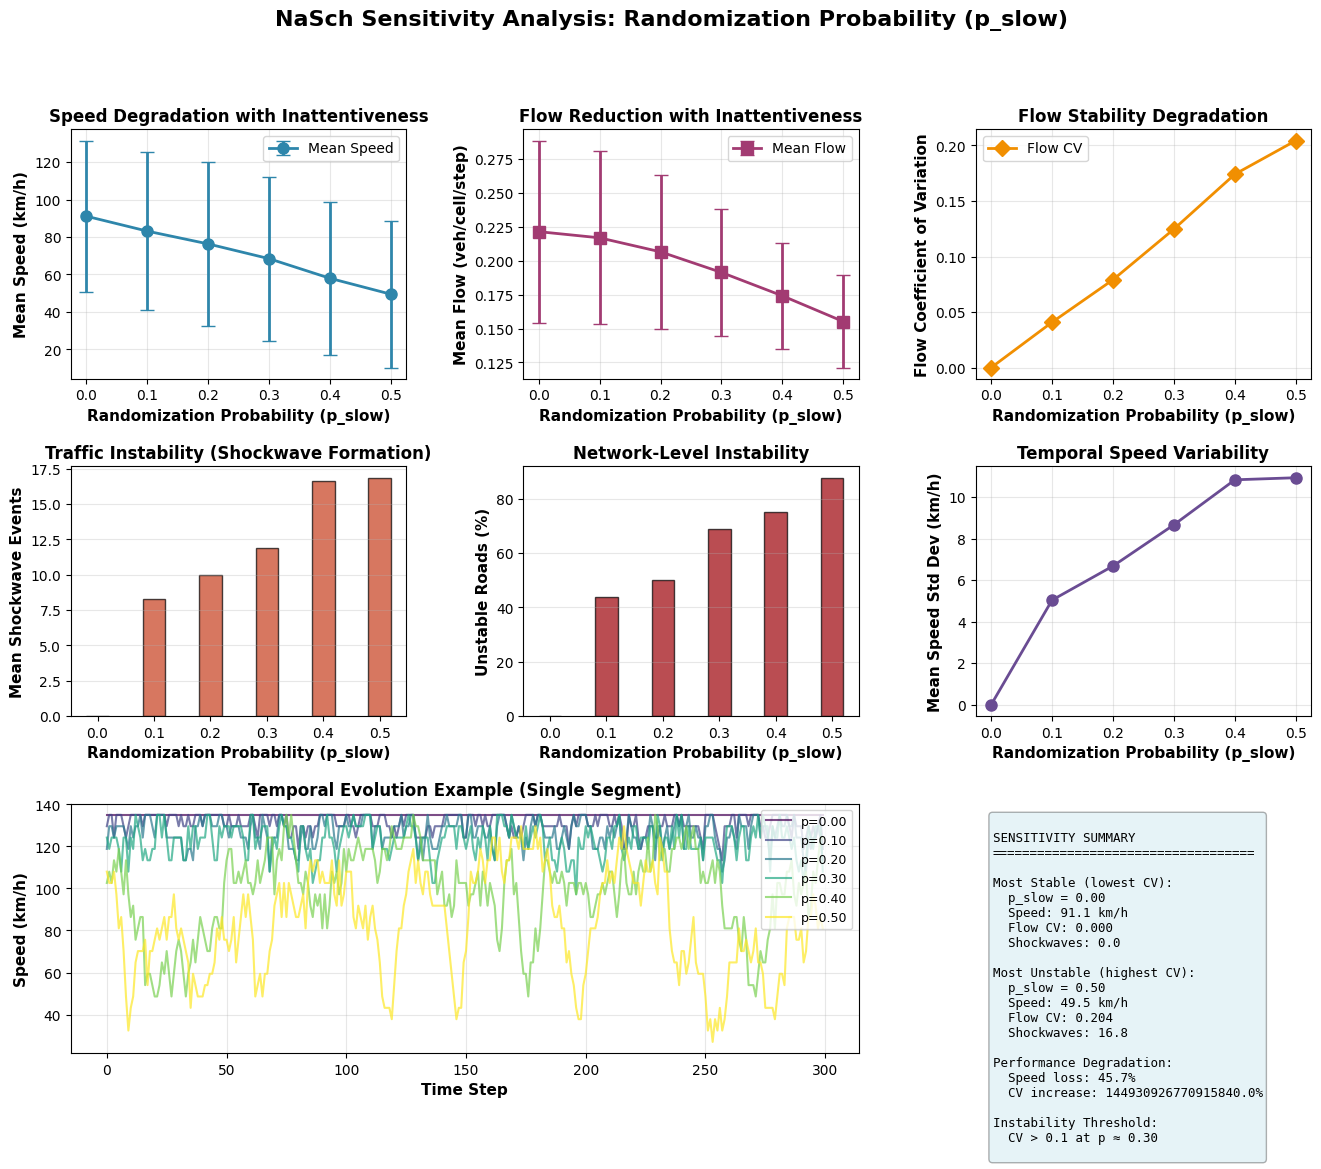


KEY FINDINGS

Speed range: 49.5 - 91.1 km/h
Flow CV range: 0.000 - 0.204
Shockwave frequency range: 0.0 - 16.8

Most stable: p_slow = 0.00
  Speed: 91.1 km/h
  Flow CV: 0.000

Most unstable: p_slow = 0.50
  Speed: 49.5 km/h
  Flow CV: 0.204


In [6]:
# ===== NASCH SENSITIVITY ANALYSIS =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
from pathlib import Path

class NaSchSensitivityAnalyzer:
    """
    Sensitivity analysis for NaSch randomization probability (p_slow).
    Tests how driver inattentiveness affects flow stability and shockwave formation.
    """
    
    def __init__(self, edges_gdf, output_dir='nasch_sensitivity_results'):
        self.edges = edges_gdf
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(exist_ok=True)
        
    def run_sensitivity_analysis(self, 
                                 p_slow_values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
                                 num_roads=100,
                                 steps=500,
                                 warmup=200):
        """
        Run sensitivity analysis across different p_slow values.
        
        Parameters
        ----------
        p_slow_values : list
            Randomization probabilities to test
        num_roads : int
            Number of road segments to sample
        steps : int
            Total simulation steps
        warmup : int
            Warmup steps to discard
        """
        
        print("\n" + "="*70)
        print("NASCH RANDOMIZATION PROBABILITY (p_slow) SENSITIVITY ANALYSIS")
        print("="*70)
        print(f"Testing {len(p_slow_values)} p_slow values on {num_roads} road segments")
        print(f"Simulation: {steps} steps ({warmup} warmup)")
        print("="*70 + "\n")
        
        # Sample road segments
        if len(self.edges) > num_roads:
            sample_edges = self.edges.sample(num_roads, random_state=42)
        else:
            sample_edges = self.edges
        
        # Extract segments
        segments = self._extract_segments(sample_edges)
        
        results = []
        
        for p_slow in tqdm(p_slow_values, desc="Testing p_slow values"):
            print(f"\n  Testing p_slow = {p_slow:.2f}")
            
            # Run simulations for this p_slow
            segment_results = []
            
            for idx, segment in segments.iterrows():
                result = self._simulate_segment_temporal(
                    segment, p_slow, steps, warmup
                )
                if result['success']:
                    segment_results.append(result)
            
            if len(segment_results) == 0:
                print(f"    WARNING: No successful simulations for p_slow={p_slow}")
                continue
            
            # Aggregate metrics across all segments
            mean_speeds = [r['mean_speed_kph'] for r in segment_results]
            mean_flows = [r['mean_flow'] for r in segment_results]
            speed_stds = [r['speed_std'] for r in segment_results]
            flow_stds = [r['flow_std'] for r in segment_results]
            shockwave_freqs = [r['shockwave_frequency'] for r in segment_results]
            
            # Network-level metrics
            agg_result = {
                'p_slow': p_slow,
                'num_segments': len(segment_results),
                
                # Speed metrics
                'mean_speed': np.mean(mean_speeds),
                'std_speed': np.std(mean_speeds),
                'mean_speed_variability': np.mean(speed_stds),
                
                # Flow metrics
                'mean_flow': np.mean(mean_flows),
                'std_flow': np.std(mean_flows),
                'mean_flow_variability': np.mean(flow_stds),
                'flow_cv': np.mean(flow_stds) / np.mean(mean_flows) if np.mean(mean_flows) > 0 else 0,
                
                # Stability metrics
                'mean_shockwave_frequency': np.mean(shockwave_freqs),
                'pct_unstable_roads': np.sum(np.array(shockwave_freqs) > 5) / len(shockwave_freqs) * 100,
                
                # Store individual results for detailed analysis
                'segment_results': segment_results
            }
            
            results.append(agg_result)
            
            print(f"    Mean Speed: {agg_result['mean_speed']:.1f} ± {agg_result['std_speed']:.1f} km/h")
            print(f"    Mean Flow: {agg_result['mean_flow']:.2f} veh/(cell·step)")
            print(f"    Flow CV: {agg_result['flow_cv']:.3f}")
            print(f"    Shockwave Freq: {agg_result['mean_shockwave_frequency']:.1f} events/segment")
            print(f"    Unstable Roads: {agg_result['pct_unstable_roads']:.1f}%")
        
        self.results_df = pd.DataFrame(results)
        
        # Save results
        self._save_results()
        
        print("\n" + "="*70)
        print("ANALYSIS COMPLETE")
        print("="*70)
        
        return self.results_df
    
    def _extract_segments(self, edges):
        """Extract road segments similar to NaSchSimulator."""
        segments = []
        
        for idx, edge in edges.iterrows():
            if isinstance(idx, tuple):
                u, v, key = idx
            else:
                u, v, key = edge.get('u', idx), edge.get('v', None), edge.get('key', 0)
            
            highway_raw = edge.get('highway', 'residential')
            if isinstance(highway_raw, list):
                highway_type = highway_raw[0] if highway_raw else 'residential'
            else:
                highway_type = str(highway_raw)
            
            length_m = edge.get('length', 500)
            speed_limit = edge.get('speed_kph', 50)
            
            if length_m < 200:  # skip very short edges
                continue
            
            segments.append({
                'edge_id': f"{u}_{v}_{key}",
                'length_m': length_m,
                'free_speed_kph': speed_limit,
                'highway_type': highway_type
            })
        
        return pd.DataFrame(segments)
    
    def _simulate_segment_temporal(self, segment, p_slow, steps, warmup):
        """
        Run NaSch simulation and track temporal evolution.
        """
        highway_type = segment['highway_type']
        
        # Highway-dependent parameters (v_max and density only; p_slow is varied)
        params = {
            'motorway':    {'v_max': 7, 'density': 0.10},
            'trunk':       {'v_max': 6, 'density': 0.12},
            'primary':     {'v_max': 5, 'density': 0.15},
            'secondary':   {'v_max': 4, 'density': 0.20},
            'tertiary':    {'v_max': 3, 'density': 0.25},
            'residential': {'v_max': 2, 'density': 0.30},
        }.get(highway_type, {'v_max': 3, 'density': 0.25})
        
        try:
            # Discretize road
            cell_len_m = 7.5
            num_cells = max(5, int(segment['length_m'] / cell_len_m))
            num_cars = int(params['density'] * num_cells)
            
            # Run simulation with temporal tracking
            speed_history, flow_history = self._run_nasch_temporal(
                num_cells, num_cars, params['v_max'], p_slow, 
                steps, warmup, segment['edge_id']
            )
            
            # Convert to km/h
            speed_history_kph = np.array(speed_history) * (cell_len_m * 3.6)
            
            # Calculate metrics
            mean_speed_kph = np.mean(speed_history_kph)
            speed_std = np.std(speed_history_kph)
            mean_flow = np.mean(flow_history)
            flow_std = np.std(flow_history)
            
            # Detect shockwaves (large fluctuations)
            flow_changes = np.abs(np.diff(flow_history))
            if len(flow_changes) > 0:
                threshold = np.percentile(flow_changes, 90)
                shockwave_frequency = np.sum(flow_changes > threshold)
            else:
                shockwave_frequency = 0
            
            return {
                'success': True,
                'highway_type': highway_type,
                'mean_speed_kph': mean_speed_kph,
                'speed_std': speed_std,
                'mean_flow': mean_flow,
                'flow_std': flow_std,
                'shockwave_frequency': shockwave_frequency,
                'speed_history': speed_history_kph,
                'flow_history': flow_history
            }
            
        except Exception as e:
            return {'success': False, 'error': str(e)}
    
    def _run_nasch_temporal(self, num_cells, num_cars, v_max, p_slow, steps, warmup, seed):
        """
        Modified NaSch that returns temporal evolution.
        """
        rng = np.random.default_rng(hash(seed) % 2**32)
        
        # Initialize
        road = -1 * np.ones(num_cells, dtype=np.int16)
        car_positions = np.sort(rng.choice(num_cells, num_cars, replace=False))
        road[car_positions] = rng.integers(0, v_max + 1, num_cars)
        
        speeds = []
        flows = []
        
        for t in range(steps):
            new_road = -1 * np.ones(num_cells, dtype=np.int16)
            car_positions = np.where(road >= 0)[0]
            
            if len(car_positions) == 0:
                speeds.append(0)
                flows.append(0)
                road = new_road
                continue
            
            # Calculate gaps
            gaps = (np.roll(car_positions, -1) - car_positions - 1) % num_cells
            
            # Update vehicles
            update_order = rng.permutation(len(car_positions))
            for idx in update_order:
                pos = car_positions[idx]
                v = road[pos]
                
                # 1. Accelerate
                v = min(v + 1, v_max)
                
                # 2. Slow to avoid collision
                v = min(v, gaps[idx])
                
                # 3. Random slow down
                if v > 0 and rng.random() < p_slow:
                    v -= 1
                
                # 4. Move
                new_pos = (pos + v) % num_cells
                new_road[new_pos] = v
            
            road = new_road
            
            # Record metrics after warmup
            if t >= warmup:
                moving = road[road >= 0]
                if moving.size > 0:
                    speeds.append(moving.mean())
                    flows.append((moving > 0).sum() / num_cells)
                else:
                    speeds.append(0)
                    flows.append(0)
        
        return speeds, flows
    
    def _save_results(self):
        """Save results to CSV."""
        timestamp = time.strftime("%Y%m%d_%H%M%S")
        
        # Save aggregate results (without nested lists)
        df_save = self.results_df.drop(columns=['segment_results'])
        csv_path = self.output_dir / f'nasch_sensitivity_{timestamp}.csv'
        df_save.to_csv(csv_path, index=False)
        print(f"\nResults saved: {csv_path}")
    
    def plot_results(self, figsize=(16, 12)):
        """Generate comprehensive visualizations."""
        
        fig = plt.figure(figsize=figsize)
        gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.35)
        
        fig.suptitle('NaSch Sensitivity Analysis: Randomization Probability (p_slow)', 
                     fontsize=16, fontweight='bold', y=0.98)
        
        # --- Row 1: Main effects ---
        
        # Speed vs p_slow
        ax1 = fig.add_subplot(gs[0, 0])
        ax1.errorbar(self.results_df['p_slow'], 
                    self.results_df['mean_speed'],
                    yerr=self.results_df['std_speed'],
                    marker='o', capsize=5, linewidth=2, markersize=8, 
                    color='#2E86AB', label='Mean Speed')
        ax1.set_xlabel('Randomization Probability (p_slow)', fontweight='bold', fontsize=11)
        ax1.set_ylabel('Mean Speed (km/h)', fontweight='bold', fontsize=11)
        ax1.set_title('Speed Degradation with Inattentiveness', fontweight='bold', fontsize=12)
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        
        # Flow vs p_slow
        ax2 = fig.add_subplot(gs[0, 1])
        ax2.errorbar(self.results_df['p_slow'], 
                    self.results_df['mean_flow'],
                    yerr=self.results_df['std_flow'],
                    marker='s', capsize=5, linewidth=2, markersize=8, 
                    color='#A23B72', label='Mean Flow')
        ax2.set_xlabel('Randomization Probability (p_slow)', fontweight='bold', fontsize=11)
        ax2.set_ylabel('Mean Flow (veh/cell/step)', fontweight='bold', fontsize=11)
        ax2.set_title('Flow Reduction with Inattentiveness', fontweight='bold', fontsize=12)
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        
        # Flow coefficient of variation
        ax3 = fig.add_subplot(gs[0, 2])
        ax3.plot(self.results_df['p_slow'], 
                self.results_df['flow_cv'],
                marker='D', linewidth=2, markersize=8, 
                color='#F18F01', label='Flow CV')
        ax3.set_xlabel('Randomization Probability (p_slow)', fontweight='bold', fontsize=11)
        ax3.set_ylabel('Flow Coefficient of Variation', fontweight='bold', fontsize=11)
        ax3.set_title('Flow Stability Degradation', fontweight='bold', fontsize=12)
        ax3.grid(True, alpha=0.3)
        ax3.legend()
        
        # --- Row 2: Stability metrics ---
        
        # Shockwave frequency
        ax4 = fig.add_subplot(gs[1, 0])
        bars = ax4.bar(self.results_df['p_slow'], 
                      self.results_df['mean_shockwave_frequency'],
                      color='#C73E1D', alpha=0.7, edgecolor='black', width=0.04)
        ax4.set_xlabel('Randomization Probability (p_slow)', fontweight='bold', fontsize=11)
        ax4.set_ylabel('Mean Shockwave Events', fontweight='bold', fontsize=11)
        ax4.set_title('Traffic Instability (Shockwave Formation)', fontweight='bold', fontsize=12)
        ax4.grid(True, alpha=0.3, axis='y')
        
        # Unstable roads percentage
        ax5 = fig.add_subplot(gs[1, 1])
        bars = ax5.bar(self.results_df['p_slow'], 
                      self.results_df['pct_unstable_roads'],
                      color='#9D0208', alpha=0.7, edgecolor='black', width=0.04)
        ax5.set_xlabel('Randomization Probability (p_slow)', fontweight='bold', fontsize=11)
        ax5.set_ylabel('Unstable Roads (%)', fontweight='bold', fontsize=11)
        ax5.set_title('Network-Level Instability', fontweight='bold', fontsize=12)
        ax5.grid(True, alpha=0.3, axis='y')
        
        # Speed variability
        ax6 = fig.add_subplot(gs[1, 2])
        ax6.plot(self.results_df['p_slow'], 
                self.results_df['mean_speed_variability'],
                marker='o', linewidth=2, markersize=8, 
                color='#6A4C93')
        ax6.set_xlabel('Randomization Probability (p_slow)', fontweight='bold', fontsize=11)
        ax6.set_ylabel('Mean Speed Std Dev (km/h)', fontweight='bold', fontsize=11)
        ax6.set_title('Temporal Speed Variability', fontweight='bold', fontsize=12)
        ax6.grid(True, alpha=0.3)
        
        # --- Row 3: Detailed analysis ---
        
        # Temporal evolution for different p_slow
        ax7 = fig.add_subplot(gs[2, 0:2])
        colors_temp = plt.cm.viridis(np.linspace(0, 1, len(self.results_df)))
        for i, row in self.results_df.iterrows():
            # Get first segment's temporal data
            if len(row['segment_results']) > 0:
                sample_result = row['segment_results'][0]
                time_steps = range(len(sample_result['speed_history']))
                ax7.plot(time_steps, sample_result['speed_history'], 
                        label=f"p={row['p_slow']:.2f}", 
                        alpha=0.7, linewidth=1.5, color=colors_temp[i])
        
        ax7.set_xlabel('Time Step', fontweight='bold', fontsize=11)
        ax7.set_ylabel('Speed (km/h)', fontweight='bold', fontsize=11)
        ax7.set_title('Temporal Evolution Example (Single Segment)', fontweight='bold', fontsize=12)
        ax7.legend(loc='upper right', fontsize=9)
        ax7.grid(True, alpha=0.3)
        
        # Summary statistics box
        ax8 = fig.add_subplot(gs[2, 2])
        ax8.axis('off')
        
        best_idx = self.results_df['flow_cv'].idxmin()
        worst_idx = self.results_df['flow_cv'].idxmax()
        
        summary_text = f"""
SENSITIVITY SUMMARY
{'='*35}

Most Stable (lowest CV):
  p_slow = {self.results_df.loc[best_idx, 'p_slow']:.2f}
  Speed: {self.results_df.loc[best_idx, 'mean_speed']:.1f} km/h
  Flow CV: {self.results_df.loc[best_idx, 'flow_cv']:.3f}
  Shockwaves: {self.results_df.loc[best_idx, 'mean_shockwave_frequency']:.1f}

Most Unstable (highest CV):
  p_slow = {self.results_df.loc[worst_idx, 'p_slow']:.2f}
  Speed: {self.results_df.loc[worst_idx, 'mean_speed']:.1f} km/h
  Flow CV: {self.results_df.loc[worst_idx, 'flow_cv']:.3f}
  Shockwaves: {self.results_df.loc[worst_idx, 'mean_shockwave_frequency']:.1f}

Performance Degradation:
  Speed loss: {(1 - self.results_df.loc[worst_idx, 'mean_speed'] / self.results_df.loc[best_idx, 'mean_speed']) * 100:.1f}%
  CV increase: {(self.results_df.loc[worst_idx, 'flow_cv'] / self.results_df.loc[best_idx, 'flow_cv'] - 1) * 100:.1f}%
  
Instability Threshold:
  CV > 0.1 at p ≈ {self.results_df[self.results_df['flow_cv'] > 0.1]['p_slow'].min():.2f}
        """
        
        ax8.text(0.05, 0.95, summary_text, transform=ax8.transAxes,
                fontsize=9, verticalalignment='top', family='monospace',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))
        
        # Save figure
        timestamp = time.strftime("%Y%m%d_%H%M%S")
        fig_path = self.output_dir / f'nasch_sensitivity_plots_{timestamp}.png'
        plt.savefig(fig_path, dpi=300, bbox_inches='tight')
        print(f"Plots saved: {fig_path}")
        
        plt.show()
        
        return fig


# ===== USAGE =====

# Initialize analyzer
nasch_analyzer = NaSchSensitivityAnalyzer(edges, output_dir='nasch_sensitivity_results')

# Run sensitivity analysis
results = nasch_analyzer.run_sensitivity_analysis(
    p_slow_values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    num_roads=100,
    steps=500,
    warmup=200
)

# Generate visualizations
nasch_analyzer.plot_results()

# Print key findings
print("\n" + "="*70)
print("KEY FINDINGS")
print("="*70)
print(f"\nSpeed range: {results['mean_speed'].min():.1f} - {results['mean_speed'].max():.1f} km/h")
print(f"Flow CV range: {results['flow_cv'].min():.3f} - {results['flow_cv'].max():.3f}")
print(f"Shockwave frequency range: {results['mean_shockwave_frequency'].min():.1f} - {results['mean_shockwave_frequency'].max():.1f}")

# Most stable configuration
best_idx = results['flow_cv'].idxmin()
print(f"\nMost stable: p_slow = {results.loc[best_idx, 'p_slow']:.2f}")
print(f"  Speed: {results.loc[best_idx, 'mean_speed']:.1f} km/h")
print(f"  Flow CV: {results.loc[best_idx, 'flow_cv']:.3f}")

# Most unstable configuration
worst_idx = results['flow_cv'].idxmax()
print(f"\nMost unstable: p_slow = {results.loc[worst_idx, 'p_slow']:.2f}")
print(f"  Speed: {results.loc[worst_idx, 'mean_speed']:.1f} km/h")
print(f"  Flow CV: {results.loc[worst_idx, 'flow_cv']:.3f}")

In [7]:
def run_param_rc(fontsize=23):
    import matplotlib.pyplot as plt
    plt.rcParams.update({
        'axes.labelsize': fontsize,
        'axes.titlesize': fontsize,
        'font.size': fontsize,
        'savefig.dpi': 75,
        'lines.linewidth': 2.0,
        'lines.markersize': 8,
        'legend.fontsize': fontsize * 0.9,
        'legend.labelspacing': .3,
        'legend.columnspacing': .3,
        'legend.handletextpad': .1,
        'text.usetex': False,                 # <- use mathtext, no LaTeX needed
        'mathtext.fontset': 'stix',
        'font.family': 'serif',
        'font.serif': ['Times New Roman', 'STIXGeneral', 'DejaVu Serif'],
    })

run_param_rc()

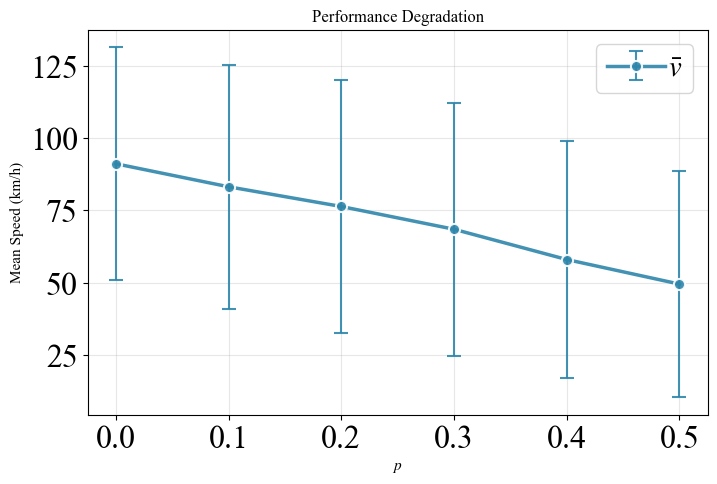

In [8]:
# Speed vs p_slow
plt.figure(figsize=(8, 5))
plt.errorbar(results['p_slow'], 
            results['mean_speed'],
            yerr=results['std_speed'],
            marker='o', capsize=5, capthick=2, linewidth=2.5, markersize=8, elinewidth=1.5,markeredgecolor='white', markeredgewidth=1.5,
            alpha=0.9, color='#2E86AB', label=r'$\bar{v}$')
plt.xlabel(r'$p$',fontsize=11)
plt.ylabel('Mean Speed (km/h)',  fontsize=11)
plt.title('Performance Degradation',  fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

/var/folders/69/8r8f20y50msgx6r9gzr30fkw0000gn/T/ipykernel_98526/3469299599.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


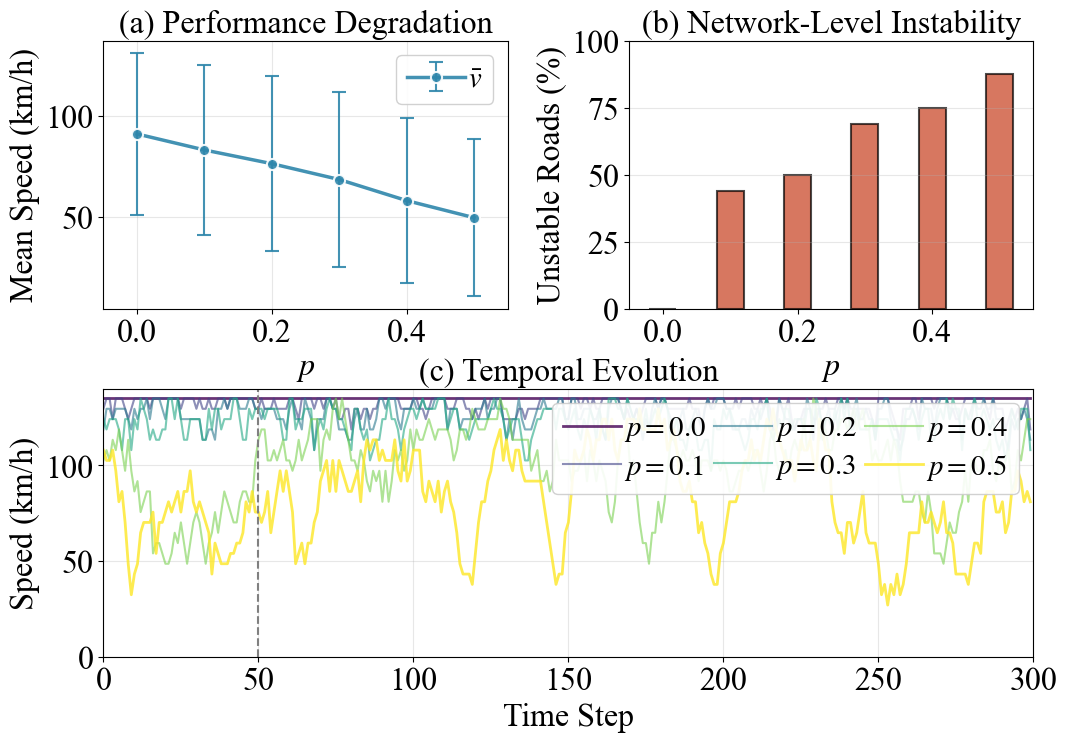

In [11]:
import matplotlib.gridspec as gridspec

# Create figure with custom layout
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.3)

# Define consistent style parameters
marker_style = {
    'marker': 'o',
    'markersize': 8,
    'markeredgecolor': 'white',
    'markeredgewidth': 1.5,
    'linewidth': 2.5,
    'capsize': 5,
    'capthick': 2,
    'elinewidth': 1.5,
    'alpha': 0.9
}

label_style = {}
title_style = {}

# ===== Panel (a): Speed Degradation =====
ax1 = fig.add_subplot(gs[0, 0])

ax1.errorbar(results['p_slow'], 
             results['mean_speed'],
             yerr=results['std_speed'],
             color='#2E86AB',
             label=r'$\bar{v}$',
             **marker_style)

ax1.set_xlabel(r'$p$', **label_style)
ax1.set_ylabel('Mean Speed (km/h)', **label_style)
ax1.set_title('(a) Performance Degradation', **title_style)
ax1.grid(True, alpha=0.3, linestyle='-', linewidth=0.8)
ax1.legend(frameon=True, framealpha=0.9)
ax1.set_xlim(-0.05, 0.55)

# Add text annotation for key finding
# speed_loss = (1 - results.iloc[-1]['mean_speed'] / results.iloc[0]['mean_speed']) * 100
# ax1.text(0.35, 0.95, f'Speed loss: {speed_loss:.1f}%', 
#          transform=ax1.transAxes, fontsize=9,
#          verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# ===== Panel (b): Network-Level Instability =====
ax2 = fig.add_subplot(gs[0, 1])

bars = ax2.bar(results['p_slow'], 
               results['pct_unstable_roads'],
               width=0.04,
               color='#C73E1D',
               alpha=0.7,
               edgecolor='black',
               linewidth=1.5)

ax2.set_xlabel(r'$p$', **label_style)
ax2.set_ylabel('Unstable Roads (%)', **label_style)
ax2.set_title('(b) Network-Level Instability', **title_style)
ax2.grid(True, alpha=0.3, axis='y', linestyle='-', linewidth=0.8)
ax2.set_xlim(-0.05, 0.55)
ax2.set_ylim(0, 100)

# Add threshold line
# ax2.axhline(y=20, color='orange', linestyle='--', linewidth=2, 
#             alpha=0.7, label='Critical threshold')
# ax2.legend(loc='upper left')

# Add value labels on bars
# for bar in bars:
#     height = bar.get_height()
#     ax2.text(bar.get_x() + bar.get_width()/2., height,
#             f'{height:.0f}%',
#             ha='center', va='bottom')

# ===== Panel (c): Temporal Evolution =====
ax3 = fig.add_subplot(gs[1, :])  # Spans both columns

# Get temporal data for different p_slow values
colors_temp = plt.cm.viridis(np.linspace(0, 1, len(results)))
p_values_to_plot = results['p_slow'].unique()
for i, p_slow in enumerate(p_values_to_plot):
    row = results[results['p_slow'] == p_slow].iloc[0]
    if len(row['segment_results']) > 0:
        # Get first segment's temporal data
        sample = row['segment_results'][0]
        time_steps = range(len(sample['speed_history']))
        
        ax3.plot(time_steps, sample['speed_history'],
                label=f'$p={p_slow:.1f}$',
                linewidth=2 if p_slow in [0.0, 0.5] else 1.5,
                alpha=0.8 if p_slow in [0.0, 0.5] else 0.6,
                color=colors_temp[i])

ax3.set_xlabel('Time Step', **label_style)
ax3.set_ylabel('Speed (km/h)', **label_style)
ax3.set_title('(c) Temporal Evolution', **title_style)
ax3.grid(True, alpha=0.3, linestyle='-', linewidth=0.8)
ax3.legend(loc='upper right',  ncol=3, frameon=True, framealpha=0.9)
ax3.set_xlim(0, len(time_steps))
ax3.set_ylim(0, 140)

# Add shaded region for warmup period
if len(time_steps) > 50:
    ax3.axvline(x=50, alpha=1, color='gray', label='Warmup', linestyle='--', linewidth=1.5)
    # ax3.text(25, 130, 'Warmup', fontsize=9, ha='center', color='black')

# Overall title
# fig.suptitle('NaSch Sensitivity Analysis: Driver Inattentiveness Effects', 
#              fontsize=14, fontweight='bold', y=0.98)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save
plt.savefig('nasch_sensitivity_3panel.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig('nasch_sensitivity_3panel.pdf', bbox_inches='tight', facecolor='white')

plt.show()

In [ ]:
results['mean_speed']

In [ ]:
results['std_speed']

In [ ]:
results